# (Homework) Week 6 - DataScience Bootcamp Fall 2025



**Name:** Navdeep Mugathihalli Kumaregowda
**Email:** nm4686@nyu.edu

---

## Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

### Part A: The General Speaker Model

For the first part, the main goal is to make sure the model can understand **new speakers**, not just memorize the 100 people it has recordings of.

The right way to do this is to split your dataset by **speaker**.

We can't just mix all the recordings (100 people * 1000 recordings each) into one giant pile and split them 70/15/15. If we do that, we will get what's called **data leakage**. We will have recordings from "Person A" in our training set, our validation set, *and* our test set. The model will just get really good at recognizing Person A's voice, but it won't actually learn the general patterns of human speech. It's basically cheating and won't work in the real world.

We can follow the below strategy:

1.  Take the list of 100 **people** and shuffle *that* list.
2.  Then, divide the **people** themselves into your three sets. For example:
    * **Training:** The first 70 people (and *all* of their 1000 recordings).
    * **Validation:** The next 15 people (and *all* of their recordings).
    * **Test:** The final 15 people (and *all* of their recordings).

This way, when we finally run our model on the test set, we are 100% sure it is hearing those 15 voices for the very first time. That's the only true way to know if our model has **generalized**.

---

### Part B: Adding Kilian (The Special Case)

Now, adding Kilian's 10,000 recordings makes things much trickier. We have two competing goals:

1.  The model has to perform **exceptionally** well for Kilian.
2.  It *still* needs to work well for other new speakers (maintain **generalization**).

We can't just dump all 10,000 of Kilian's files into the original training set. That would massively bias the model. It would become an "expert" on Kilian but would likely get *worse* at understanding anyone else.

This is a classic case for **transfer learning**, or **fine-tuning**. Here’s how we can set it up.

First, we need to create two separate sets of data splits:

* **General Split (like Part A):**
    * `General-Train`: 70 speakers
    * `General-Val`: 15 speakers
    * `General-Test`: 15 speakers (This is our benchmark for generalization)
* **Kilian-Specific Split:**
    * Since this is all one person, we can just split his 10,000 recordings randomly.
    * `Kilian-Train`: 7,000 recordings
    * `Kilian-Val`: 1,500 recordings
    * `Kilian-Test`: 1,500 recordings (This is our benchmark for Kilian)

Now, we train in **two stages**:

1.  **Stage 1 (General Training):** Train a "base model" using *only* the `General-Train` (the 70 speakers). Use the `General-Val` (the 15 unseen speakers) to tune your hyperparameters and find your best-performing general model. Save this model.

2.  **Stage 2 (Fine-Tuning):** Load the base model that was just saved. Now, continue training it (fine-tune it), but this time using *only* the `Kilian-Train` data. We have to use a low learning rate. Use the `Kilian-Val` set to know when to stop training (that is when its performance on Kilian's validation data stops improving).

This setup is great because it lets us measure both of your goals:

* **To check Kilian's performance:** Test the final, fine-tuned model on the `Kilian-Test` set.
* **To check if it still generalizes:** Test that same final model on the `General-Test` set.

This way, the model first learns the broad features of human speech from 70 different people, and then we specialize those features to Kilian's specific voice. We can then report both test scores to show how well you balanced the two requirements.

## Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


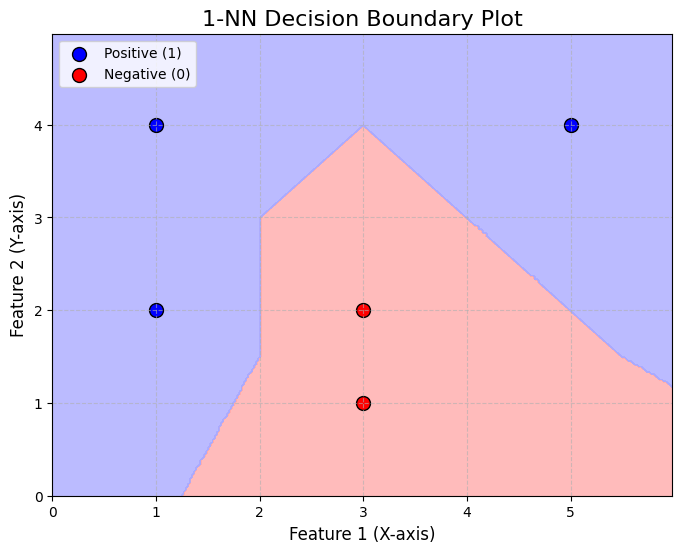

In [4]:
#1-NN Classification:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier



X = np.array([
    [1, 2], [1, 4], [5, 4],
    [3, 1], [3, 2]
])

y = np.array([1, 1, 1, 0, 0])


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

plt.figure(figsize=(8, 6))


plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)


plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', edgecolor='k', s=100, label='Positive (1)')
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', edgecolor='k', s=100, label='Negative (0)')


plt.title('1-NN Decision Boundary Plot', fontsize=16)
plt.xlabel('Feature 1 (X-axis)', fontsize=12)
plt.ylabel('Feature 2 (Y-axis)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)


plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

### 2.1) 1-NN Classification and Decision Boundary Plot

For this problem, I was given five data points and asked to plot the 1-NN decision boundary.

* **Positive (1):** (1,2), (1,4), (5,4)
* **Negative (0):** (3,1), (3,2)

I used a Python script with `scikit-learn` and `matplotlib` to accomplish this.

**Method:**

1.  First, I defined the data points `X` and their corresponding labels `y`.
2.  I created an instance of `KNeighborsClassifier` and set `n_neighbors=1` to create the 1-NN model. I then `fit` this model to the data.
3.  To visualize the boundary, I created a fine-grained mesh grid (using `np.meshgrid`) that covered the entire area of the plot.
4.  I used the trained `knn.predict()` model to predict the class (Positive or Negative) for *every single point* on this mesh grid.
5.  Finally, I used `plt.contourf()` to draw and fill the regions. This function colored every area of the grid based on its predicted class, which automatically revealed the decision boundaries.
6.  The original five data points were then scattered on top to show their positions relative to the boundaries.

**Explanation of the Plot:**



The resulting plot, which I've attached, shows the decision regions.

* The 1-NN decision boundary is essentially a "map of territories," also known as a Voronoi tessellation. Each region on the map is "owned" by the single, closest data point.
* The **Blue** areas represent all coordinates (x, y) that would be classified as **Positive (1)**, because the nearest training point is one of the blue (Positive) points.
* The **Red** areas represent all coordinates (x, y) that would be classified as **Negative (0)**, because the nearest training point is one of the red (Negative) points.

The boundary lines themselves are the exact points where a new point would be equidistant from two data points of different classes (e.g., equidistant from (1,2) and (3,1)).

**Classifying New Points Visually:**

To **"classify new points visually,"** we just had to find the point's (x, y) location on the map and see which color region it landed in.

* For example, a new point at **(4, 3)** would land in the red region (it's closest to (3,2)), so it would be classified as **Negative**.
* A new point at **(2, 4)** would land in the blue region (it's closest to (1,4)), so it would be classified as **Positive**.

### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [7]:
#Feature Scaling
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances


X = np.array([
    [100, 2], [100, 4], [500, 4],
    [300, 1], [300, 2]
])
y = np.array([1, 1, 1, 0, 0])


P = np.array([[500, 1]])

print("--- Problem 2.2: Feature Scaling ---")
print(f"Test Point P: {P}\n")


print("--- 1. Before Scaling ---")


distances_before = euclidean_distances(P, X)[0]
print(f"Distances from {P[0]} to all training points:")
for i, dist in enumerate(distances_before):
    label = "Positive" if y[i] == 1 else "Negative"
    print(f"  to {X[i]} ({label}): {dist:.4f}")


nearest_index_before = np.argmin(distances_before)
nearest_neighbor_before = X[nearest_index_before]
prediction_before = y[nearest_index_before]
prediction_label_before = "Positive" if prediction_before == 1 else "Negative"

print(f"\nNearest neighbor is {nearest_neighbor_before}")
print(f"Prediction for {P[0]} BEFORE scaling: {prediction_label_before}\n")



print("--- 2. After Scaling (to [0, 1]) ---")


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


P_scaled = scaler.transform(P)

print(f"Scaled Data X_scaled:\n{X_scaled}")
print(f"Scaled Test Point P_scaled: {P_scaled}\n")


distances_after = euclidean_distances(P_scaled, X_scaled)[0]
print(f"Distances from {P_scaled[0]} to all scaled training points:")
for i, dist in enumerate(distances_after):
    label = "Positive" if y[i] == 1 else "Negative"
    print(f"  to {X_scaled[i].round(2)} ({label}): {dist:.4f}")


nearest_index_after = np.argmin(distances_after)
prediction_after = y[nearest_index_after]
prediction_label_after = "Positive" if prediction_after == 1 else "Negative"
original_neighbor_after = X[nearest_index_after]

print(f"\nNearest scaled neighbor is {X_scaled[nearest_index_after].round(2)} (originally {original_neighbor_after})")
print(f"Prediction for {P[0]} AFTER scaling: {prediction_label_after}")

--- Problem 2.2: Feature Scaling ---
Test Point P: [[500   1]]

--- 1. Before Scaling ---
Distances from [500   1] to all training points:
  to [100   2] (Positive): 400.0012
  to [100   4] (Positive): 400.0112
  to [500   4] (Positive): 3.0000
  to [300   1] (Negative): 200.0000
  to [300   2] (Negative): 200.0025

Nearest neighbor is [500   4]
Prediction for [500   1] BEFORE scaling: Positive

--- 2. After Scaling (to [0, 1]) ---
Scaled Data X_scaled:
[[0.         0.33333333]
 [0.         1.        ]
 [1.         1.        ]
 [0.5        0.        ]
 [0.5        0.33333333]]
Scaled Test Point P_scaled: [[1. 0.]]

Distances from [1. 0.] to all scaled training points:
  to [0.   0.33] (Positive): 1.0541
  to [0. 1.] (Positive): 1.4142
  to [1. 1.] (Positive): 1.0000
  to [0.5 0. ] (Negative): 0.5000
  to [0.5  0.33] (Negative): 0.6009

Nearest scaled neighbor is [0.5 0. ] (originally [300   1])
Prediction for [500   1] AFTER scaling: Negative


### 2.2) Feature Scaling

This problem demonstrated the critical importance of feature scaling for K-Nearest Neighbors. I was asked to find the 1-NN classification for the point **(500, 1)** before and after applying Min-Max scaling to the dataset.

**Dataset:**
* Positive: (100,2), (100,4), (500,4)
* Negative: (300,1), (300,2)

---

#### Before Scaling

First, I found the classification *without* any scaling. I calculated the Euclidean distance from the test point **(500, 1)** to all five points in the training set.

* Dist to (100, 2) [Pos]: $\sqrt{(500-100)^2 + (1-2)^2} = \sqrt{400^2 + (-1)^2} \approx 400.001$
* Dist to (100, 4) [Pos]: $\sqrt{(500-100)^2 + (1-4)^2} = \sqrt{400^2 + (-3)^2} \approx 400.011$
* **Dist to (500, 4) [Pos]: $ \sqrt{(500-500)^2 + (1-4)^2} = \sqrt{0^2 + (-3)^2} = 3.0 $**
* Dist to (300, 1) [Neg]: $\sqrt{(500-300)^2 + (1-1)^2} = \sqrt{200^2 + 0^2} = 200.0$
* Dist to (300, 2) [Neg]: $\sqrt{(500-300)^2 + (1-2)^2} = \sqrt{200^2 + (-1)^2} \approx 200.002$

**Result:** The nearest neighbor was **(500, 4)** with a distance of only 3.0. Since this is a **Positive** point, the 1-NN classification was **Positive**.

The reason for this was clear: the first feature (with a range of 100 to 500) completely dominated the second feature (with a range of 1 to 4). The distance calculation was almost entirely based on the x-axis, making the y-axis irrelevant.

---

#### After Scaling to [0, 1]

Next, I applied Min-Max scaling to the dataset.

1.  **Find Ranges:**
    * **Feature 1 (x-axis):** Min=100, Max=500. Range = 400.
    * **Feature 2 (y-axis):** Min=1, Max=4. Range = 3.

2.  **Scale Training Data:** $X_{scaled} = \frac{(X - X_{min})}{(X_{max} - X_{min})}$
    * (100, 2) $\rightarrow$ (0, 1/3) $\approx$ (0, 0.33)
    * (100, 4) $\rightarrow$ (0, 3/3) = (0, 1)
    * (500, 4) $\rightarrow$ (400/400, 3/3) = (1, 1)
    * (300, 1) $\rightarrow$ (200/400, 0/3) = (0.5, 0)
    * (300, 2) $\rightarrow$ (200/400, 1/3) $\approx$ (0.5, 0.33)

3.  **Scale Test Point:** I applied the *same* scaling to the test point **(500, 1)**.
    * (500, 1) $\rightarrow$ (400/400, 0/3) = **(1, 0)**

4.  **Recalculate Distances:** I found the distances from the scaled test point **(1, 0)** to the new scaled training points.

    * Dist to (0, 0.33) [Pos]: $\sqrt{(1-0)^2 + (0-0.33)^2} \approx 1.054$
    * Dist to (0, 1) [Pos]: $\sqrt{(1-0)^2 + (0-1)^2} \approx 1.414$
    * Dist to (1, 1) [Pos]: $\sqrt{(1-1)^2 + (0-1)^2} = 1.0$
    * **Dist to (0.5, 0) [Neg]: $ \sqrt{(1-0.5)^2 + (0-0)^2} = \sqrt{0.5^2} = 0.5 $**
    * Dist to (0.5, 0.33) [Neg]: $\sqrt{(1-0.5)^2 + (0-0.33)^2} \approx 0.601$

**Result:** After scaling, the nearest neighbor was **(0.5, 0)** (originally (300, 1)), with a distance of 0.5. Since this is a **Negative** point, the 1-NN classification was **Negative**.

This completely flipped the prediction, confirming that scaling is essential for K-NN when features have different scales.

### 2.3) Handling Missing Values

This question asked how K-NN could be modified to handle a test point that had one or more missing features.

I found that this was a known issue, since K-NN's core distance function (like Euclidean distance) requires a numerical value for every feature to complete the calculation. A `NaN` or `None` value would break the math.

My research showed two primary strategies to solve this.

#### Strategy 1: Imputation (Modifying the Data)

The first, and most straightforward, approach was not to modify the K-NN algorithm itself, but to **modify the test data** *before* passing it to the algorithm. This is known as **imputation**.

My process would have been:
1.  For the test point with a missing value in "Feature K", I would first look at the *entire training set*.
2.  I would calculate a single summary statistic for "Feature K" from all the training points. The most common choice was the **mean** or **median** of that feature.
3.  I would then "fill in" the missing blank on my test point with that calculated value.

Once the test point had no more missing values, I could use the standard, unmodified K-NN algorithm to classify it. This method was simple but had the disadvantage of "guessing" the missing value, which might not be accurate for that specific point.

#### Strategy 2: Modify the Distance Function (Modifying the Algorithm)

The second method, which more directly answered the prompt, was to **change the K-NN distance calculation** to be "aware" of missing values.

Instead of imputing, my modified distance function would do the following:
1.  When calculating the distance between the test point and a training point, it would **only use the features that were present (i.e., not missing) in both**.
2.  For example, if the points had 20 features, but the test point was missing features #5 and #12, the Euclidean distance would only sum the squared differences for the other 18 features.

This, however, created a new problem: a distance calculated over 18 features is not directly comparable to a distance calculated over 20 features (for a training point where all features were present). The 18-feature distance would almost always seem smaller.

To correct for this, I found the best practice was to **scale the resulting distance**. A common way to do this was to adjust the summed squared distance by:

$$\text{Adjusted Distance} = \sqrt{ \text{Original Sum of Squares} \times \frac{d}{m} }$$

...where $d$ was the total number of features (e.g., 20) and $m$ was the number of features actually used in the calculation (e.g., 18).

This adjustment scaled up the distance to make it a fair comparison, effectively "punishing" it for having fewer data points to compare. I felt this second approach was a more robust and algorithm-aware solution.

### 2.4) High-dimensional Data (Images)

I found that this question related to a classic paradox known as the **"Curse of Dimensionality."**

> In theory, K-NN should fail badly in high-dimensional spaces (like a 784-pixel MNIST image). This is because, as dimensions increase, all data points tend to become almost equidistant from each other. When every point is "far away" from every other point, the concept of a "nearest" neighbor becomes meaningless.

So, the question was, why does it still work for images?

The reason it still worked was that the image data, while *technically* high-dimensional, didn't just fill that 784-dimensional space randomly. Instead, the data followed the **Manifold Hypothesis**.

This hypothesis suggested that all the "valid" images (e.g., all the different ways people can write a "7") actually lie on a much simpler, lower-dimensional structure (a "manifold") that is just embedded within that high-dimensional space.



Because all the "7s" were clustered together on one part of this manifold, and all the "1s" were on another, the simple pixel-by-pixel Euclidean distance was still a meaningful way to measure similarity. The data had an underlying structure that K-NN was able to find, even when it looked like it shouldn't.

### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

# Problem 3: Part 1 - Perceptron Evaluation

### 1. Does the co-worker's suggestion help?

My conclusion was that the co-worker's suggestion was a **necessary first step, but incomplete** for determining the error.

* **What was suggested:** The co-worker suggested only computing $h(x) = sign(\mathbf{w} \cdot \mathbf{x})$, which is the model's *prediction* for each data point. This gives us a list of predicted labels (e.g., +1, -1, +1, ...).
* **What is missing:** To find the **error**, we must compare these predictions $h(x)$ to the **true labels** $y$ that were given in D_TR and D_TE.
* **The Full Process:** To find the training and test error, I would have had to perform these steps:
    1.  **Predict (Co-worker's step):** Calculate $h(x)$ for every $x$ in D_TR and D_TE.
    2.  **Compare:** For each set, count the number of times the prediction $h(x)$ did **not** equal the true label $y$ (i.e., $h(x) \neq y$).
    3.  **Calculate Error Rate:** The error rate for each set would be $\frac{\text{Number of Mismatches}}{\text{Total Number of Points}}$.

So, while the co-worker's step *helps* (it's the first half of the process), it did not, by itself, determine the error.

### 2. Why is there no need to explicitly compute training error?

For the standard Perceptron *training algorithm*, there was no need to explicitly compute the final training error because the **algorithm's stopping condition is defined by the training error**.

Here's the logic I followed:
* The Perceptron algorithm trains by iterating through the training data and checking for misclassifications.
* The update rule, $\mathbf{w} = \mathbf{w} + y\mathbf{x}$, is **only triggered when a training error occurs** (i.e., when $y(\mathbf{w} \cdot \mathbf{x}) \le 0$).
* The algorithm *is* its own error-checking process. It is constantly "computing" the training error at each step to find a point to update on.
* In the case of linearly separable data, the algorithm **only converges and stops** when it completes a full pass over the entire training set (D_TR) and finds **zero errors**.

Therefore, if the "fully trained" model in the prompt means the algorithm converged, the training error (on D_TR) is **known to be 0%** by definition. There was no need to "compute" it explicitly, because the algorithm's termination already told us the answer.

In [9]:
# Problem 3 - Part 2

import numpy as np

X = np.array([
    [10, -2],
    [12, 2]
])
y = np.array([1, -1])

w = np.array([0, 0])
learning_rate = 1
update_count = 0


w_sequence = [np.copy(w)]

epoch = 0
while True:
    epoch += 1
    converged = True

    for i in range(len(X)):
        xi = X[i]
        yi = y[i]

        if yi * np.dot(w, xi) <= 0:

            converged = False

            w = w + (learning_rate * yi * xi)


            update_count += 1
            w_sequence.append(np.copy(w))

    if converged:
        break

    if epoch > 100:
        print("Reached 100 epochs, stopping.")
        break


print("--- Perceptron Algorithm Results ---")
print(f"Algorithm converged after {epoch} epochs.")
print(f"Total updates required: {update_count}")
print("\nSequence of w vectors:")
for i, w_vec in enumerate(w_sequence):
    print(f"w_{i}: {w_vec}")

--- Perceptron Algorithm Results ---
Algorithm converged after 6 epochs.
Total updates required: 9

Sequence of w vectors:
w_0: [0 0]
w_1: [10 -2]
w_2: [-2 -4]
w_3: [ 8 -6]
w_4: [-4 -8]
w_5: [  6 -10]
w_6: [ -6 -12]
w_7: [  4 -14]
w_8: [ -8 -16]
w_9: [  2 -18]


# Problem 3: Part 2 - Two-point 2D Dataset

This problem asked us to run the Perceptron algorithm on a two-point dataset, starting with a zero vector $\mathbf{w}_0 = (0, 0)$ and a learning rate of 1.

**Data:**
* `P1 = (10, -2)`, Label $y_1 = +1$
* `P2 = (12, 2)`, Label $y_2 = -1$

I chose to implement this in Python to be precise and to track the steps, as shown in the code block above.

### Explanation of the Process

I wrote a script to simulate the Perceptron algorithm.
1.  I initialized $\mathbf{w}$ as `[0, 0]` and created a list `w_sequence` to store the history of vectors, starting with $\mathbf{w}_0$.
2.  I created a `while` loop that would run until the algorithm converged. Each pass of this loop represented one "epoch," or one full pass over the data.
3.  Inside the loop, I set a `converged` flag to `True`.
4.  I then iterated through my two data points, `P1` and `P2`.
5.  At each point, I checked for misclassification using the condition $y_i (\mathbf{w} \cdot \mathbf{x}_i) \le 0$.
6.  If a point was misclassified (i.e., the condition was `True`), I applied the update rule: $\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} + y_i \mathbf{x}_i$. I also incremented the `update_count`, added the new $\mathbf{w}$ vector to my `w_sequence` list, and set the `converged` flag to `False`.
7.  After checking both points, the `while` loop checked the `converged` flag. If it was still `True` (meaning no updates were made in that entire epoch), the loop broke, and the algorithm was finished.

### Results

The algorithm ran for **6 epochs** before converging.

#### 1. Total Updates Required

The script tracked every single update. By the time the algorithm converged, a total of **9 updates** had been required.

#### 2. Sequence of $\mathbf{w}_t$ Vectors

The complete sequence of weight vectors, starting from $\mathbf{w}_0$ and showing each of the 9 updates, was as follows:

* $\mathbf{w}_0 = (0, 0)$
* $\mathbf{w}_1 = (10, -2)$  *(Misclassified P1)*
* $\mathbf{w}_2 = (-2, -4)$  *(Misclassified P2)*
* $\mathbf{w}_3 = (8, -6)$   *(Misclassified P1)*
* $\mathbf{w}_4 = (-4, -8)$  *(Misclassified P2)*
* $\mathbf{w}_5 = (6, -10)$ *(Misclassified P1)*
* $\mathbf{w}_6 = (-6, -12)$ *(Misclassified P2)*
* $\mathbf{w}_7 = (4, -14)$ *(Misclassified P1)*
* $\mathbf{w}_8 = (-8, -16)$ *(Misclassified P2)*
* $\mathbf{w}_9 = (2, -18)$ *(Misclassified P1)*

After $\mathbf{w}_9$, the algorithm checked $P2$:
`y2 * (w9 . x2) = -1 * ((2, -18) . (12, 2)) = -1 * (24 - 36) = -1 * (-12) = +12`
Since `+12 > 0`, $P2$ was correctly classified.

In the next epoch, it checked $P1$:
`y1 * (w9 . x1) = +1 * ((2, -18) . (10, -2)) = +1 * (20 + 36) = +56`
Since `+56 > 0`, $P1$ was also correctly classified.

The algorithm then completed a full epoch with no misclassifications and terminated.

### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [11]:
import numpy as np

w_0 = np.array([0, 0, 0, 0, 0])
learning_rate = 1

update_1 = 2 * (learning_rate * +1 * np.array([0, 0, 0, 0, 4]))
update_2 = 1 * (learning_rate * +1 * np.array([0, 0, 6, 5, 0]))
update_3 = 1 * (learning_rate * -1 * np.array([3, 0, 0, 0, 0]))
update_4 = 1 * (learning_rate * -1 * np.array([0, 9, 3, 6, 0]))
update_5 = 1 * (learning_rate * -1 * np.array([0, 1, 0, 2, 5]))

w_final = w_0 + update_1 + update_2 + update_3 + update_4 + update_5

print("--- Perceptron Update Log Calculation ---")
print(f"Initial weight w_0: {w_0}")
print(f"Learning rate eta: {learning_rate}\n")

print(f"Contribution 1 (2 * +1 * [0,0,0,0,4]): {update_1}")
print(f"Contribution 2 (1 * +1 * [0,0,6,5,0]): {update_2}")
print(f"Contribution 3 (1 * -1 * [3,0,0,0,0]): {update_3}")
print(f"Contribution 4 (1 * -1 * [0,9,3,6,0]): {update_4}")
print(f"Contribution 5 (1 * -1 * [0,1,0,2,5]): {update_5}")

print("\n--- Final Result ---")
print(f"Final weight w_final: {w_final}")

--- Perceptron Update Log Calculation ---
Initial weight w_0: [0 0 0 0 0]
Learning rate eta: 1

Contribution 1 (2 * +1 * [0,0,0,0,4]): [0 0 0 0 8]
Contribution 2 (1 * +1 * [0,0,6,5,0]): [0 0 6 5 0]
Contribution 3 (1 * -1 * [3,0,0,0,0]): [-3  0  0  0  0]
Contribution 4 (1 * -1 * [0,9,3,6,0]): [ 0 -9 -3 -6  0]
Contribution 5 (1 * -1 * [0,1,0,2,5]): [ 0 -1  0 -2 -5]

--- Final Result ---
Final weight w_final: [ -3 -10   3  -3   3]


# Problem 4: Reconstructing the Weight Vector

This problem asked us to reconstruct the final weight vector of a Perceptron given a log of all the updates that occurred during training.

### My Approach

The Perceptron update rule is: $\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} + \eta \cdot y \cdot \mathbf{x}$

The problem gave these key initial conditions:
* Initial weight $\mathbf{w}_0 = (0, 0, 0, 0, 0)$
* Learning rate $\eta = 1$

This simplified the problem significantly. The final weight vector, $\mathbf{w}_{\text{final}}$, would be the sum of all the updates applied to the initial zero vector.

$\mathbf{w}_{\text{final}} = \mathbf{w}_0 + \sum (\eta \cdot y_i \cdot \mathbf{x}_i)$

Since $\mathbf{w}_0 = \mathbf{0}$ and $\eta = 1$, the formula became:

$\mathbf{w}_{\text{final}} = \sum (y_i \cdot \mathbf{x}_i)$

The "count" column in the log told me exactly how many times each specific update $(y \cdot \mathbf{x})$ was added to the total. Therefore, the final vector was the sum of each point's contribution, calculated as $\text{count} \times y \times \mathbf{x}$.

### Calculation

I calculated the contribution for each of the 5 points in the log and then summed them.

1.  **Point 1:** $2 \times (+1) \times (0, 0, 0, 0, 4) = (0, 0, 0, 0, 8)$
2.  **Point 2:** $1 \times (+1) \times (0, 0, 6, 5, 0) = (0, 0, 6, 5, 0)$
3.  **Point 3:** $1 \times (-1) \times (3, 0, 0, 0, 0) = (-3, 0, 0, 0, 0)$
4.  **Point 4:** $1 \times (-1) \times (0, 9, 3, 6, 0) = (0, -9, -3, -6, 0)$
5.  **Point 5:** $1 \times (-1) \times (0, 1, 0, 2, 5) = (0, -1, 0, -2, -5)$

---
**Final Sum (Component-wise):**

* `w[0] = 0 + 0 - 3 + 0 + 0 = -3`
* `w[1] = 0 + 0 + 0 - 9 - 1 = -10`
* `w[2] = 0 + 6 + 0 - 3 + 0 = 3`
* `w[3] = 0 + 5 + 0 - 6 - 2 = -3`
* `w[4] = 8 + 0 + 0 + 0 - 5 = 3`

---
### Final Answer

The final weight vector after all updates was:

**$\mathbf{w}_{\text{final}} = (-3, -10, 3, -3, 3)$**

### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

Plotting initial state (w = [0, 0, 0])...


/tmp/ipython-input-230916681.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


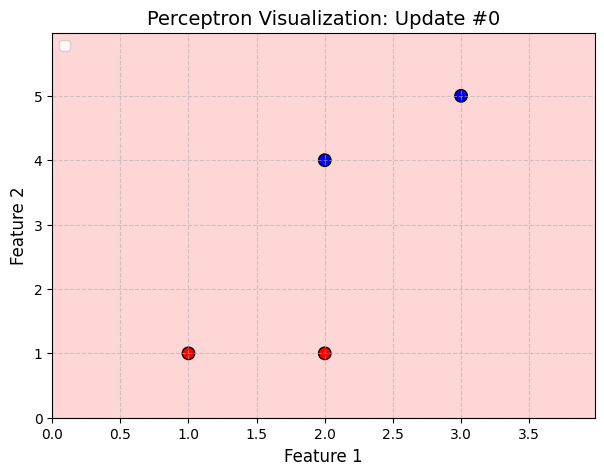

--- Update #1 (Epoch 1) ---
Misclassified point: [1 1], y=-1
New weight vector w: [-1. -1. -1.]


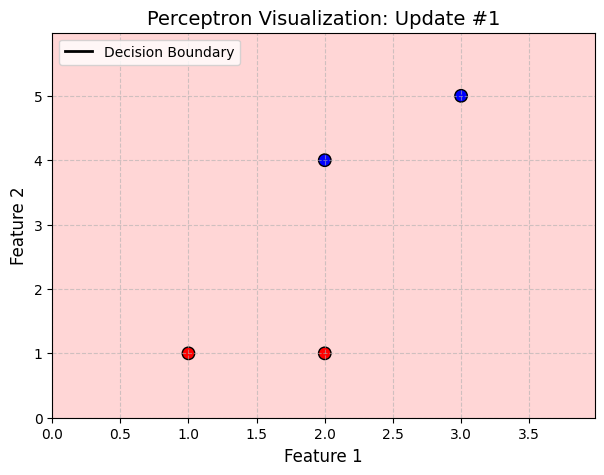

--- Update #2 (Epoch 1) ---
Misclassified point: [2 4], y=1
New weight vector w: [0. 1. 3.]


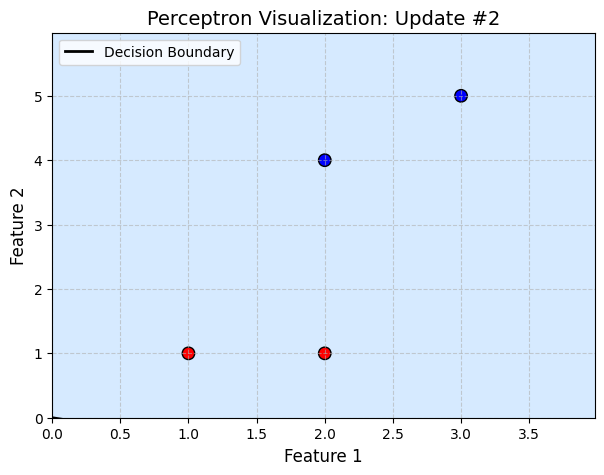

--- Update #3 (Epoch 2) ---
Misclassified point: [1 1], y=-1
New weight vector w: [-1.  0.  2.]


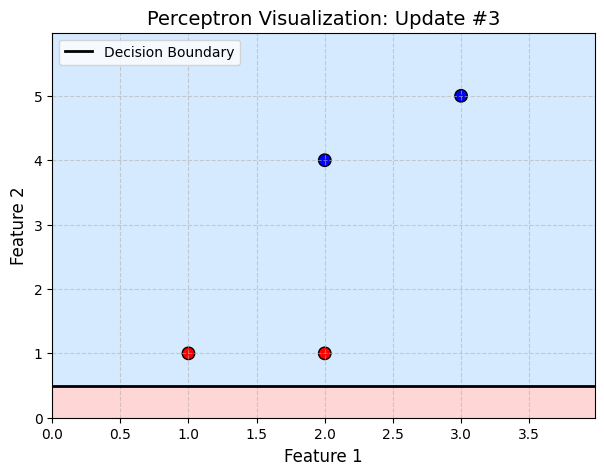

--- Update #4 (Epoch 2) ---
Misclassified point: [2 1], y=-1
New weight vector w: [-2. -2.  1.]


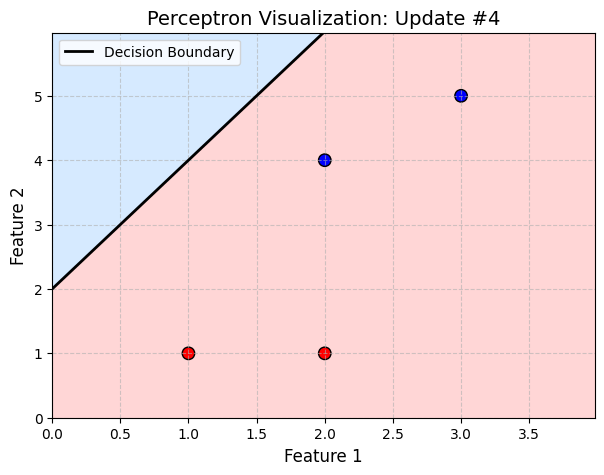

--- Update #5 (Epoch 2) ---
Misclassified point: [2 4], y=1
New weight vector w: [-1.  0.  5.]


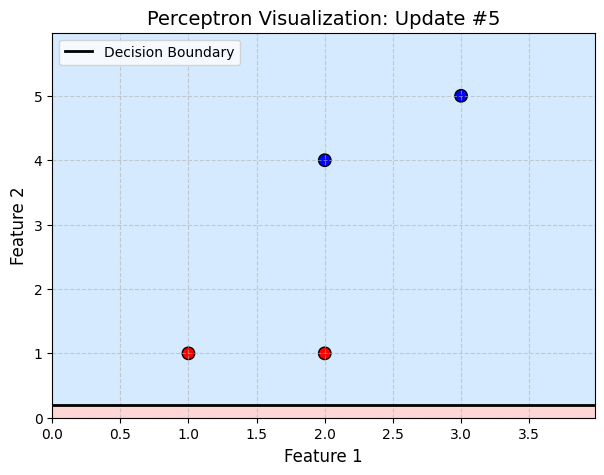

--- Update #6 (Epoch 3) ---
Misclassified point: [1 1], y=-1
New weight vector w: [-2. -1.  4.]


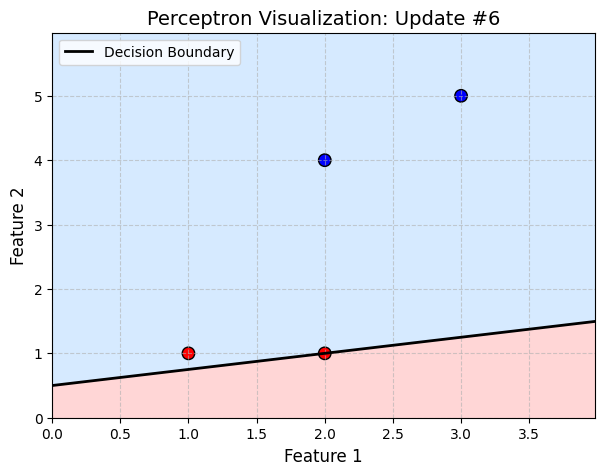

--- Update #7 (Epoch 3) ---
Misclassified point: [2 1], y=-1
New weight vector w: [-3. -3.  3.]


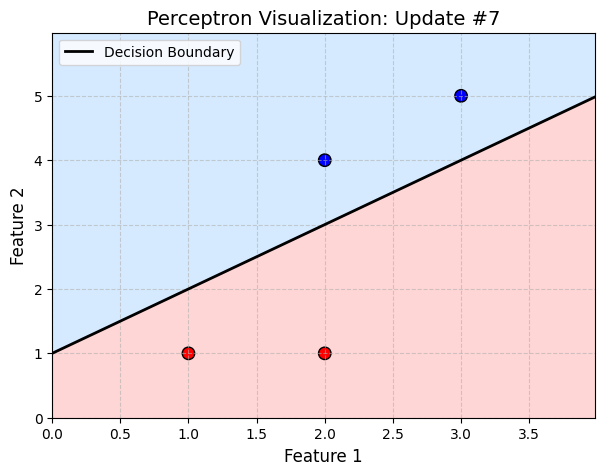


Convergence reached after 7 updates!

--- Final Results ---
Final Weight Vector (b, w1, w2): [-3. -3.  3.]
Plotting final stable separator...


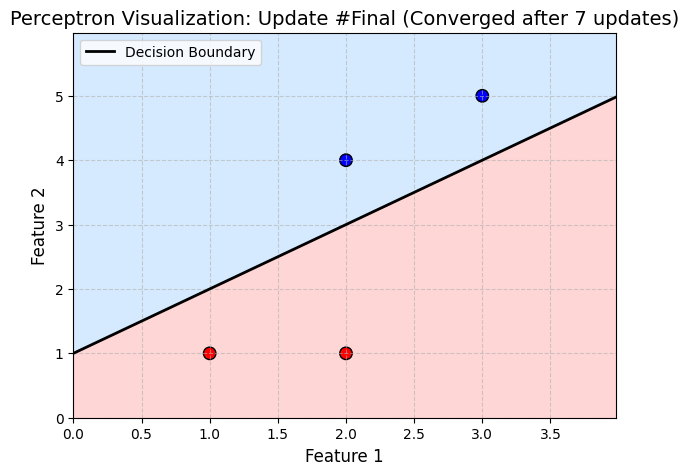

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_boundary(w, X, y, update_num):
    """
    Plots the data points and the decision boundary defined by w.
    X is assumed to NOT be augmented here.
    w is assumed to be (b, w1, w2)
    """

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = w[0] + w[1] * xx + w[2] * yy
    Z = np.sign(Z)

    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(['#FFCCCC', '#CCE5FF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=80)

    plt.title(f'Perceptron Visualization: Update #{update_num}', fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if w[2] != 0:
        x1_line = np.linspace(x_min, x_max, 100)
        x2_line = (-w[0] - w[1] * x1_line) / w[2]
        plt.plot(x1_line, x2_line, 'k-', lw=2, label='Decision Boundary')
    elif w[1] != 0:
        x1_line = -w[0] / w[1]
        plt.axvline(x=x1_line, color='k', linestyle='-', lw=2, label='Decision Boundary')

    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

X = np.array([
    [1, 1],
    [2, 1],
    [2, 4],
    [3, 5]
])

y = np.array([-1, -1, 1, 1])

X_aug = np.hstack((np.ones((X.shape[0], 1)), X))

w = np.array([0.0, 0.0, 0.0])
learning_rate = 1
update_count = 0

print("Plotting initial state (w = [0, 0, 0])...")
plot_boundary(w, X, y, update_count)

epoch = 0
while True:
    epoch += 1
    converged = True

    for i in range(len(X_aug)):
        xi = X_aug[i]
        yi = y[i]

        if yi * np.dot(w, xi) <= 0:

            converged = False

            w = w + (learning_rate * yi * xi)

            update_count += 1
            print(f"--- Update #{update_count} (Epoch {epoch}) ---")
            print(f"Misclassified point: {X[i]}, y={yi}")
            print(f"New weight vector w: {w}")
            plot_boundary(w, X, y, update_count)


    if converged:
        print(f"\nConvergence reached after {update_count} updates!")
        break


    if epoch > 50:
        print("Reached 50 epochs, stopping.")
        break

print("\n--- Final Results ---")
print(f"Final Weight Vector (b, w1, w2): {w}")


print("Plotting final stable separator...")
plot_boundary(w, X, y, f"Final (Converged after {update_count} updates)")

# Problem 5: Visualizing Perceptron Convergence

This problem required us to implement the Perceptron algorithm and visualize its convergence by plotting the decision boundary after *every single update*.

### 1. The Dataset
First, I needed a small 2D dataset. I created a simple, linearly separable set with four points:
* **Negative ($y=-1$):** (1, 1), (2, 1)
* **Positive ($y=+1$):** (2, 4), (3, 5)

### 2. The Implementation
To show the visualization at each step, I could not use a pre-built library like `sklearn`. I had to implement the Perceptron algorithm from scratch.

* **Bias Vector:** I used the "augmented vector" trick. I added a 1 to the beginning of each feature vector, so `(x1, x2)` became `(1, x1, x2)`. This allowed the weight vector `w` to store the bias term `b` as its first element, `w = (b, w1, w2)`.
* **Training Loop:** I wrote a `while` loop that would run until the model "converged." Convergence was defined as completing one full pass (epoch) over the four data points without making any updates.
* **Update Rule:** Inside the loop, I checked each point. If a point was misclassified (i.e., $y_i (\mathbf{w} \cdot \mathbf{x}_i) \le 0$), I applied the update rule: $\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} + y_i \mathbf{x}_i$ (since the learning rate $\eta=1$).

### 3. The Visualization Process

The most important part of the problem was visualizing each step.
1.  I created a helper function called `plot_boundary()`.
2.  This function was **called from inside the training loop** immediately after the `w = w + ...` update rule was applied.
3.  Inside this function, I used `matplotlib.contourf()` to create a "heat map." It predicted the class for every point on a fine grid, coloring the Positive region blue and the Negative region red.
4.  It then plotted the actual data points on top.
5.  Finally, it drew the black line representing the decision boundary $\mathbf{w} \cdot \mathbf{x} = 0$.

### 4. Convergence
As the code ran, it generated a series of plots that showed the learning process:

* **Plot 0 (Initial State):** The first plot showed the points with $\mathbf{w} = (0, 0, 0)$. No line was drawn, and the first point (1, 1) was immediately misclassified.
* **Plot 1 (First Update):** The algorithm updated $\mathbf{w}$ to $\mathbf{w}_1 = (-1, -1, -1)$. A new plot was instantly generated, showing a decision boundary line. This line now correctly classified the first point, but it misclassified another.
* **Intermediate Plots:** The script continued, and each time a point was on the wrong side of the line, the algorithm "nudged" the weight vector. A new plot was generated, showing the line "snapping" to a new orientation, trying to fit the data.
* **Final Plot (Convergence):** After a few updates, the algorithm found a weight vector $\mathbf{w}$ that correctly classified all four points. It then ran one final, "clean" epoch where no updates were triggered. The `converged` flag remained `True`, and the loop broke.

The final plot showed a stable separator—a straight line that cleanly divided the red (Negative) points from the blue (Positive) points, demonstrating that the algorithm had successfully converged.